In [2]:
# EDA for
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
import gc

# Metrics
from sklearn.metrics import (
    mean_squared_error
)

from tensorflow.keras.metrics import RootMeanSquaredError

# Models

import keras_tuner
from keras import *
from scikeras.wrappers import KerasRegressor
from keras import Sequential
from keras.layers import (
    Dense, 
    Dropout,
)

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold,
    train_test_split,
    GridSearchCV,
    KFold,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from catboost import *

# Any
import warnings
warnings.filterwarnings('ignore')

In [3]:
class CFG:
    TARGET = 'nivel_y'
    N_FOLDS = 3
    RANDOM_STATE = 87

    TRAIN_PATH_1 = './data/2024_08_10 16_20_01.csv'
    TRAIN_PATH_2 = './data/2024_08_10 18_25_52.csv'
    TRAIN_PATH_3 = './data/2024_08_10 14_31_28.csv'

    TEST_PATH_1 = './test/test1.csv'
    TEST_PATH_2 = './test/test2.csv'
    # TEST_PATH_3 = './test/test3.csv'
    # TEST_PATH_4 = './test/test4.csv'

In [4]:
df_end = pd.read_csv(CFG.TRAIN_PATH_1)
df_start = pd.read_csv(CFG.TRAIN_PATH_2)
df_start_0 = pd.read_csv(CFG.TRAIN_PATH_3)

df_test_1 = pd.read_csv(CFG.TEST_PATH_1)
df_test_2 = pd.read_csv(CFG.TEST_PATH_2)

In [5]:
train = pd.concat([df_end[200:],df_start_0, df_start, ], ignore_index=True)
test = pd.concat([df_test_1, df_test_2], ignore_index=True)

<Axes: >

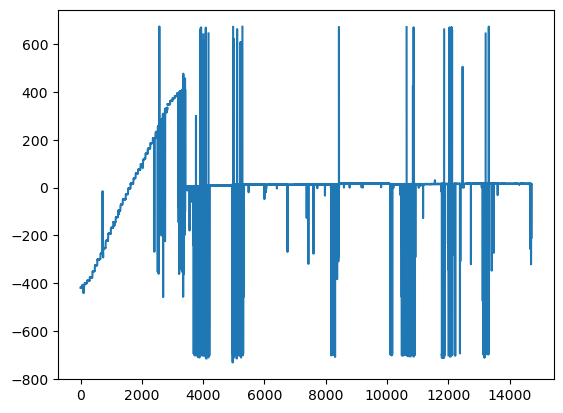

In [6]:
train['center_bubbles_px'].plot()

<Axes: >

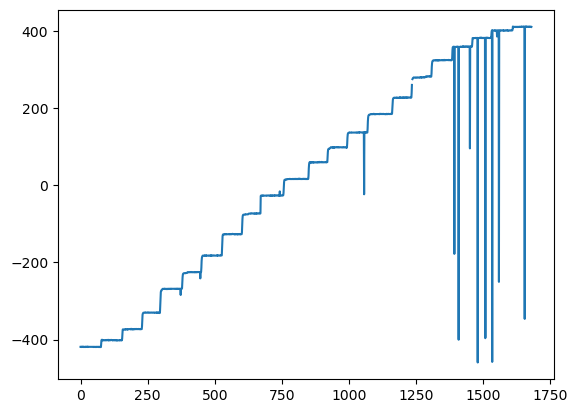

In [7]:
test['center_bubbles_px'].plot()

In [8]:
train = train.loc[(train['watch_indicator'] != 'False') &
                (train['watch_indicator'] != 'None')]
train = train.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

test = test.loc[(test['watch_indicator'] != 'False') &
                (test['watch_indicator'] != 'None')]
test = test.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])


In [9]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
for i in train.columns:
    if i not in [CFG.TARGET, 'temperature']:
        train[i] = train[i].interpolate()
        test[i] = test[i].interpolate()

In [10]:
def agg_features(df, suffix=''):
    X = pd.DataFrame()    
    X[suffix+"median"] = df.median(axis=1)
    X[suffix+"mean"] = df.mean(axis=1)
    X[suffix+"std"] = df.std(axis=1)
    X[suffix+"max"] = df.max(axis=1)
    X[suffix+"min"] = df.min(axis=1)
    X["length"] = np.sqrt(df['1']**2 - df['center_bubbles_px']**2)
    return X

In [11]:
train = train.join(agg_features(train), how='left')
test = test.join(agg_features(test), how='left')

In [12]:
for i in train.columns:
    if i not in [CFG.TARGET, 'temperature']:
        train[i] = train[i].rolling(5).median()
        train[i].fillna(0, inplace=True)
        test[i] = test[i].rolling(5).median()
        test[i].fillna(0, inplace=True)

In [13]:
features = train.drop([CFG.TARGET], axis=1)
target = train[CFG.TARGET]

# Cat

In [16]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [17]:
def build_catboost(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'random_strength': trial.suggest_float('random_strength', .1, 1., log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', .1, 1., log=True),
        'bootstrap_type':'Bayesian',
        'task_type': 'GPU',
        'loss_function':'RMSE'
    }

    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(features_train, target_train),
        model.get_params(),
        verbose=False
    )
    return np.min(cv_data['test-RMSE-mean'])

In [292]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=10)

[I 2024-08-13 14:25:44,858] A new study created in memory with name: no-name-c4097c78-f09e-4210-b86c-e53fd9cb1a14


Training on fold [0/3]
bestTest = 0.3757787185
bestIteration = 999
Training on fold [1/3]
bestTest = 0.3769087345
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:26:10,667] Trial 0 finished with value: 0.3754283461470973 and parameters: {'learning_rate': 2.715284736897375e-05, 'depth': 2, 'l2_leaf_reg': 0.121776443836594, 'random_strength': 0.10856148656045597, 'bagging_temperature': 0.15073039555913262}. Best is trial 0 with value: 0.3754283461470973.


bestTest = 0.3735975854
bestIteration = 999
Training on fold [0/3]
bestTest = 0.3844049223
bestIteration = 999
Training on fold [1/3]
bestTest = 0.385564433
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:26:36,616] Trial 1 finished with value: 0.3840885141244767 and parameters: {'learning_rate': 1.0697947520485665e-06, 'depth': 2, 'l2_leaf_reg': 0.22320039710806858, 'random_strength': 0.2778036443798266, 'bagging_temperature': 0.813802401891455}. Best is trial 0 with value: 0.3754283461470973.


bestTest = 0.3822961871
bestIteration = 999
Training on fold [0/3]
bestTest = 0.1436975592
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1450721055
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:27:05,893] Trial 2 finished with value: 0.14487822137768866 and parameters: {'learning_rate': 0.0011277975907394674, 'depth': 3, 'l2_leaf_reg': 0.4132549126125381, 'random_strength': 0.5339924883786491, 'bagging_temperature': 0.19206766752621499}. Best is trial 2 with value: 0.14487822137768866.


bestTest = 0.1458649995
bestIteration = 999
Training on fold [0/3]
bestTest = 0.05780001687
bestIteration = 999
Training on fold [1/3]
bestTest = 0.06251853039
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:27:35,275] Trial 3 finished with value: 0.062203020176525625 and parameters: {'learning_rate': 0.0022993764036819144, 'depth': 3, 'l2_leaf_reg': 0.7713265544212191, 'random_strength': 0.5760289776571772, 'bagging_temperature': 0.21308880010487735}. Best is trial 3 with value: 0.062203020176525625.


bestTest = 0.06629051327
bestIteration = 999
Training on fold [0/3]
bestTest = 0.3843368141
bestIteration = 999
Training on fold [1/3]
bestTest = 0.3854979596
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:30:32,633] Trial 4 finished with value: 0.3840230451457453 and parameters: {'learning_rate': 1.1284920612573305e-06, 'depth': 10, 'l2_leaf_reg': 0.22046785562222668, 'random_strength': 0.8899368562359165, 'bagging_temperature': 0.893565406486294}. Best is trial 3 with value: 0.062203020176525625.


bestTest = 0.3822343617
bestIteration = 999
Training on fold [0/3]
bestTest = 0.3812746332
bestIteration = 999
Training on fold [1/3]
bestTest = 0.382422325
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:32:17,179] Trial 5 finished with value: 0.38095889137303174 and parameters: {'learning_rate': 9.297882654190222e-06, 'depth': 9, 'l2_leaf_reg': 0.14874579433002583, 'random_strength': 0.25455781613379097, 'bagging_temperature': 0.1440192667646143}. Best is trial 3 with value: 0.062203020176525625.


bestTest = 0.3791797159
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2325216982
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2333032259
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:32:48,111] Trial 6 finished with value: 0.23241269125402023 and parameters: {'learning_rate': 0.0005470990568418442, 'depth': 4, 'l2_leaf_reg': 0.4837852567823422, 'random_strength': 0.6544143136146383, 'bagging_temperature': 0.2626737212013574}. Best is trial 3 with value: 0.062203020176525625.


bestTest = 0.2314131497
bestIteration = 999
Training on fold [0/3]
bestTest = 0.3315708933
bestIteration = 999
Training on fold [1/3]
bestTest = 0.3323582092
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:33:37,881] Trial 7 finished with value: 0.3311464858495843 and parameters: {'learning_rate': 0.00015318258689300953, 'depth': 7, 'l2_leaf_reg': 0.1276064401834121, 'random_strength': 0.17908115452006768, 'bagging_temperature': 0.44053125767769863}. Best is trial 3 with value: 0.062203020176525625.


bestTest = 0.329510355
bestIteration = 999
Training on fold [0/3]
bestTest = 0.02249146944
bestIteration = 999
Training on fold [1/3]
bestTest = 0.03877952736
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:34:03,518] Trial 8 finished with value: 0.031230830265981873 and parameters: {'learning_rate': 0.009269758529666102, 'depth': 1, 'l2_leaf_reg': 0.8446873115594863, 'random_strength': 0.1915914636689479, 'bagging_temperature': 0.475137889628741}. Best is trial 8 with value: 0.031230830265981873.


bestTest = 0.032421494
bestIteration = 999
Training on fold [0/3]
bestTest = 0.01931016127
bestIteration = 999
Training on fold [1/3]
bestTest = 0.03225713043
bestIteration = 999
Training on fold [2/3]


[I 2024-08-13 14:37:24,542] Trial 9 finished with value: 0.023771852026802903 and parameters: {'learning_rate': 0.0035126355120445726, 'depth': 9, 'l2_leaf_reg': 0.8060770761995323, 'random_strength': 0.15664871956654064, 'bagging_temperature': 0.25137877292309135}. Best is trial 9 with value: 0.023771852026802903.


bestTest = 0.01974826438
bestIteration = 999


In [293]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.0035126355120445726, 'depth': 9, 'l2_leaf_reg': 0.8060770761995323, 'random_strength': 0.15664871956654064, 'bagging_temperature': 0.25137877292309135}
Best RMSE: 0.023771852026802903


In [18]:
rmses = []
preds = []
skf = KFold(n_splits=20)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train[CFG.TARGET])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in [CFG.TARGET]]]
    y_train = train.loc[train_idx, CFG.TARGET]
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, CFG.TARGET]
    X_test = test[X_train.columns]



    X_train_pool = Pool(X_train, y_train)
    X_valid_pool = Pool(X_valid, y_valid)
    X_test_pool = Pool(X_test)


    model = CatBoostRegressor(
        loss_function='RMSE',
        learning_rate=0.0035126355120445726,
        iterations=10000,
        depth=9,
        l2_leaf_reg=0.8060770761995323,
        random_strength=0.15664871956654064,
        bagging_temperature=0.25137877292309135,
        bootstrap_type='Bayesian',
        task_type='GPU',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=200)

    pred_valid = model.predict(X_valid_pool)
    preds.append(model.predict(X_test_pool))

    rmse = mean_squared_error(y_valid, pred_valid)**.5
    rmses.append(rmse)
    
    del X_train, y_train, X_valid, y_valid, X_test
    gc.collect()

    print(f'Fold {fold+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.median(rmse):.5f} +/- {np.std(rmse):.5f}')

### Fold 1 Training ###
0:	learn: 0.2895571	test: 1.1594800	best: 1.1594800 (0)	total: 76.3ms	remaining: 12m 43s
500:	learn: 0.0519385	test: 0.7069550	best: 0.7069550 (500)	total: 19s	remaining: 5m 59s
1000:	learn: 0.0105837	test: 0.6430844	best: 0.6430844 (1000)	total: 37.8s	remaining: 5m 40s
1500:	learn: 0.0052344	test: 0.6210608	best: 0.6210608 (1500)	total: 56.6s	remaining: 5m 20s
2000:	learn: 0.0049501	test: 0.6173773	best: 0.6173773 (2000)	total: 1m 12s	remaining: 4m 50s
2500:	learn: 0.0049386	test: 0.6158370	best: 0.6158356 (2493)	total: 1m 24s	remaining: 4m 14s
3000:	learn: 0.0049034	test: 0.6148218	best: 0.6148218 (3000)	total: 1m 38s	remaining: 3m 50s
3500:	learn: 0.0048224	test: 0.6136935	best: 0.6136862 (3498)	total: 1m 55s	remaining: 3m 33s
bestTest = 0.6136694356
bestIteration = 3564
Shrink model to first 3565 iterations.
Fold 1 RMSE: 0.61367

### Fold 2 Training ###
0:	learn: 0.3770775	test: 0.4177761	best: 0.4177761 (0)	total: 40.4ms	remaining: 6m 43s
500:	learn: 0.0671

In [19]:
pd.DataFrame(rmses).median()

0    0.0016
dtype: float64

In [37]:
r = model.predict(test[train.columns])

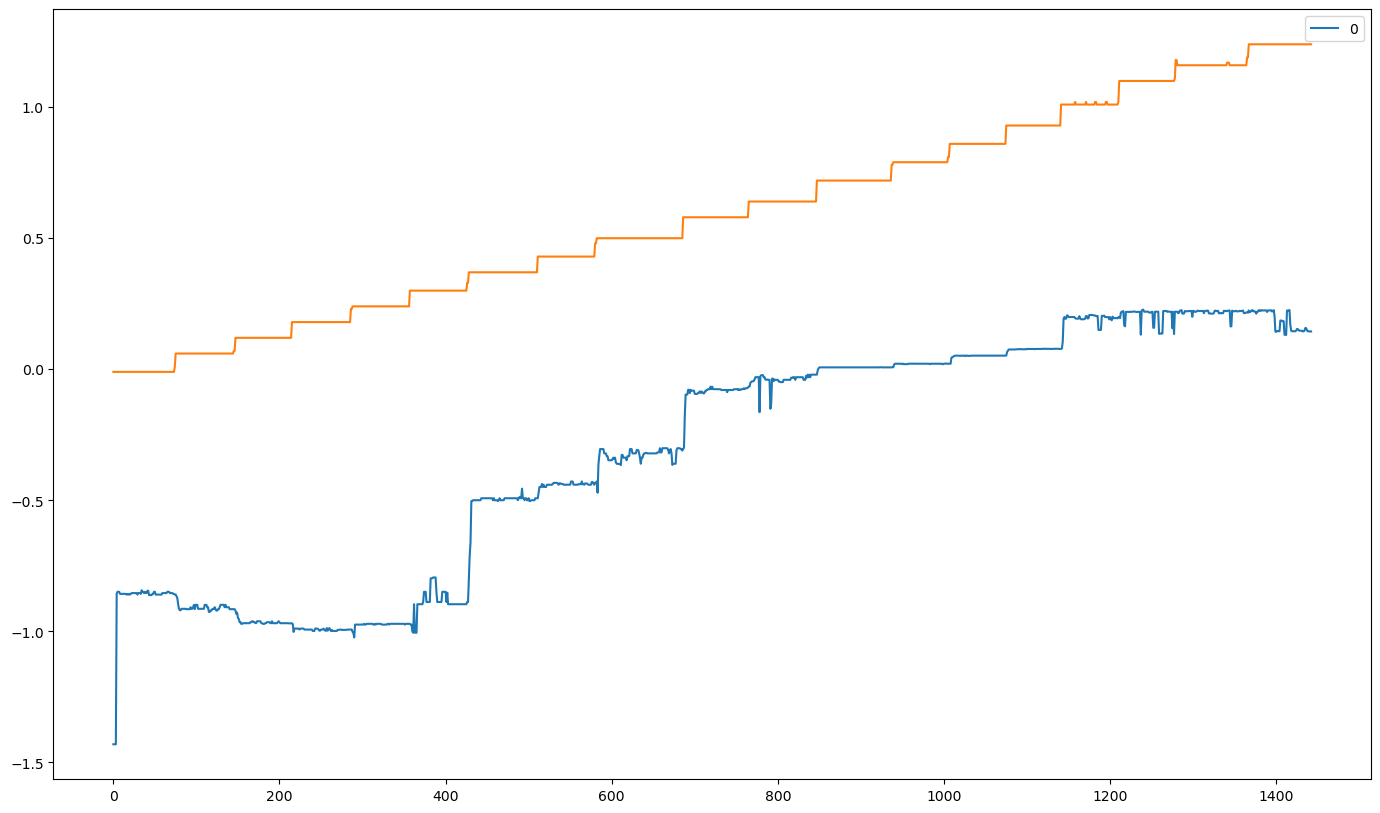

In [39]:
pd.DataFrame(r).plot(figsize=(17,10));test[CFG.TARGET].plot();

In [300]:
dif = test[CFG.TARGET] - pd.DataFrame(preds).median()

<Axes: >

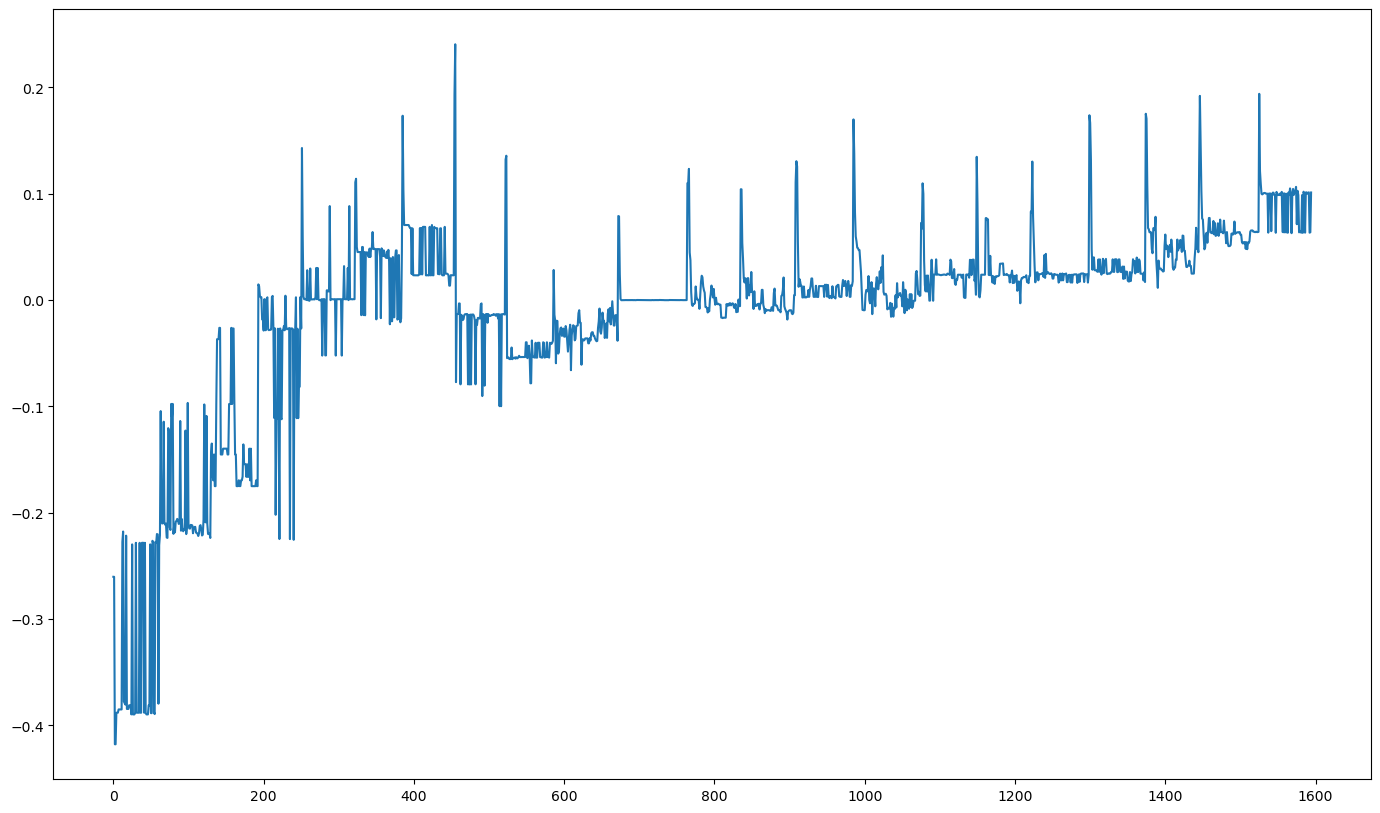

In [301]:
dif.plot(figsize=(17,10))

In [243]:
model.save_model('model_v_2')

# NN

In [14]:
features

,center_bubbles_px,temperature,1,2,3,4,5,6,7,8,...,97,98,99,100,median,mean,std,max,min,length
0,0.0,26.1250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,26.1250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000
2,0.0,26.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,26.1250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000
4,-418.5,26.1250,-602.0,709.0,-602.0,706.0,-601.0,711.0,-601.0,710.0,...,-534.0,708.0,-533.0,707.0,-1.48,58.855777,632.943462,715.0,-602.0,432.737507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14201,16.0,26.6875,-176.0,715.0,-176.0,709.0,-175.0,707.0,-175.0,708.0,...,-140.0,698.5,-139.0,697.5,16.00,265.686796,429.619960,717.0,-176.0,175.271218
14202,16.0,26.6875,-176.0,714.0,-176.0,709.0,-175.0,707.0,-175.0,708.0,...,-141.0,691.0,-140.0,706.0,16.00,265.686796,430.453418,718.0,-176.0,175.271218
14203,16.0,26.7500,-176.0,714.0,-176.0,709.0,-175.0,707.0,-175.0,708.0,...,-141.0,698.5,-140.0,697.5,16.00,265.123083,430.328484,717.0,-176.0,175.271218
14204,15.5,26.7500,-177.0,712.0,-177.0,710.0,-176.0,708.0,-176.0,709.0,...,-141.0,698.5,-140.0,706.0,15.50,265.123083,430.328484,717.0,-177.0,175.271218


In [15]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [16]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [17]:
def build_model():
    model_nn = Sequential()
    model_nn.add(Dense(32, activation='tanh'))
    model_nn.add(Dense(1))
    model_nn.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=[RootMeanSquaredError()])
    return model_nn

In [18]:
model_nn = build_model()

model_nn.fit(
    features_train,
    target_train,
    epochs=100
)

Epoch 1/100
333/333 [==============================] - 0s 566us/step - loss: 0.0229 - root_mean_squared_error: 0.1512
Epoch 2/100
333/333 [==============================] - 0s 569us/step - loss: 0.0036 - root_mean_squared_error: 0.0599
Epoch 3/100
333/333 [==============================] - 0s 566us/step - loss: 0.0029 - root_mean_squared_error: 0.0534
Epoch 4/100
333/333 [==============================] - 0s 551us/step - loss: 0.0022 - root_mean_squared_error: 0.0465
Epoch 5/100
333/333 [==============================] - 0s 554us/step - loss: 0.0018 - root_mean_squared_error: 0.0430
Epoch 6/100
333/333 [==============================] - 0s 572us/step - loss: 0.0017 - root_mean_squared_error: 0.0413
Epoch 7/100
333/333 [==============================] - 0s 557us/step - loss: 0.0017 - root_mean_squared_error: 0.0409
Epoch 8/100
333/333 [==============================] - 0s 563us/step - loss: 0.0014 - root_mean_squared_error: 0.0379
Epoch 9/100
333/333 [==============================] - 0

In [19]:
def build_neural_network(hp):    
    model = Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=128, max_value=1024, step=64),
                activation=hp.Choice("activation", ["tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [20]:
build_neural_network(keras_tuner.HyperParameters())

In [21]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_root_mean_squared_error', 'min'),
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
)

In [22]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [23]:
X_train, X_val, y_train, y_val = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [24]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Trial 5 Complete [00h 09m 02s]
val_root_mean_squared_error: 0.020136764893929165

Best val_root_mean_squared_error So Far: 0.020136764893929165
Total elapsed time: 00h 21m 15s


In [25]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [26]:
callback = EarlyStopping(monitor='loss', patience=100)

In [27]:
best_NN.fit(
    X_train,  
    y_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000


333/333 [==============================] - 1s 3ms/step - loss: 0.0445 - root_mean_squared_error: 0.2110
Epoch 2/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771
Epoch 3/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741
Epoch 4/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726
Epoch 5/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708
Epoch 6/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697
Epoch 7/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676
Epoch 8/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659
Epoch 9/10000
333/333 [==============================] - 1s 3ms/step -

In [28]:
ynew = best_NN.predict(features)
class_probabilities = np.hstack((1-ynew, ynew))

444/444 [==============================] - 1s 1ms/step


In [189]:
target

0      -0.01
1      -0.01
2      -0.01
3      -0.01
4      -0.01
        ... 
7663    1.50
7664    1.50
7665    1.50
7666    1.50
7667    1.50
Name: nivel_y, Length: 7668, dtype: float64

In [190]:
pred = pd.DataFrame(ynew)

In [191]:
np.sqrt(mean_squared_error(target, pred))

0.026182164995101342

<Axes: >

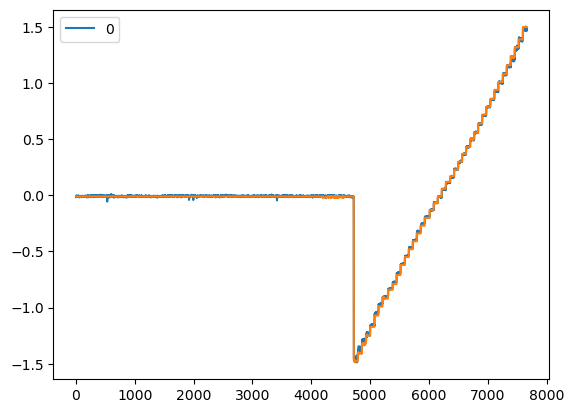

In [192]:
pred.plot(); target.plot()

In [193]:
dif = target - pred[0]

In [194]:
dif.std()

0.025986164382474093

In [195]:
dif.mean()

-0.0032113998970169882

# Test NN

In [198]:
test_df = pd.read_csv('./test/test1.csv')

In [199]:
test_df = test_df.loc[(test_df['watch_indicator'] != 'False') &
(test_df['watch_indicator'] != 'None')]
test_df = test_df.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

In [200]:
test_df = test_df.reset_index(drop=True)
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        test_df[i] = test_df[i].interpolate()

In [201]:
test_df = test_df.join(agg_features(test_df), how='left')

In [202]:
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        print(i)
        test_df[i] = test_df[i].rolling(5).median()
        test_df[i].fillna(0, inplace=True)

center_bubbles_px
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
median
mean
std
max
min


In [203]:
features = test_df.drop([CFG.TARGET],axis=1)
target = test_df[CFG.TARGET]

In [204]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [205]:
pred = best_NN.predict(features)

19/19 [==============================] - 0s 833us/step


In [206]:
pred = pd.DataFrame(pred)

In [207]:
np.sqrt(mean_squared_error(target, pred))

0.3847204189031395

<Axes: >

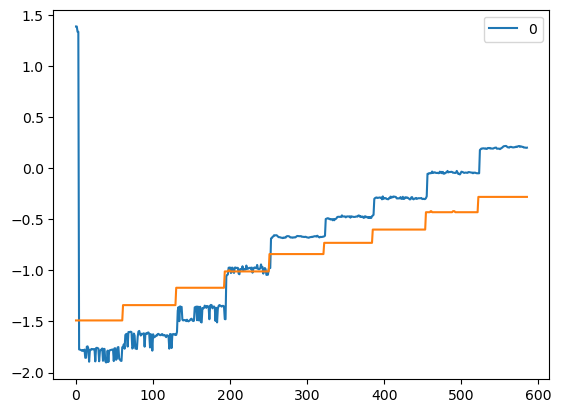

In [208]:
pd.DataFrame(pred).plot();target.plot()